In [226]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [227]:
#Question 1. True trajectory
T = 2
N = 26
#Initial state vector
X_true_0 = np.array([[13500/np.sqrt(2)], [-50], [13500/np.sqrt(2)], [-45]])
#State vector
X_true = np.zeros((4, N))
#Transition matrix
Phi = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
#Range and azimuth
D_0 = np.sqrt(X_true_0[0] ** 2 + X_true_0[2]**2)
D_true = np.zeros((N, 1))

betta_0 = np.arctan(X_true_0[0]/X_true_0[2])
betta_true = np.zeros((N, 1))

#Observation matrix
H = np.array([[1, 0]])


def true_trajectory_(X_0_1, N):
    X_0_ = np.zeros((4, N))
    D_ = np.zeros((N, 1))
    betta_ = np.zeros((N, 1))

    for n in range (N):
        if n == 0:
            X_0_[:, n] = Phi.dot(X_0_1).reshape(-1)
        else:
            X_0_[:, n] = Phi.dot(X_0_[:, n-1].reshape(4, 1)).reshape(-1)
    D_ = np.sqrt(X_0_[0, :] ** 2 + X_0_[2, :] ** 2)
    betta_= np.arctan(X_0_[0, :]/X_0_[2, :])
    return X_0_, D_, betta_

X_true, D_true, betta_true = true_trajectory_(X_true_0, N)
""" D_true = true_trajectory_(X_true_0, N)[1]
betta_true = true_trajectory_(X_true_0, N)[2] """


' D_true = true_trajectory_(X_true_0, N)[1]\nbetta_true = true_trajectory_(X_true_0, N)[2] '

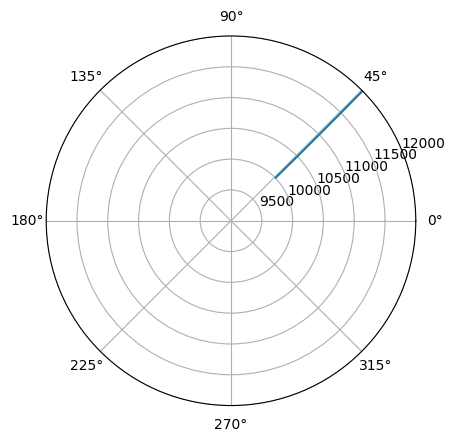

In [228]:
#Question 2. Polar plot of true trajectory
plt.polar(betta_true, D_true)
plt.ylim(9000,12000)
plt.show()

In [229]:
#Quastion 3
sigma_D_ = 20
sigma_betta_ = 0.02
D_meas = np.zeros((N, 1))
betta_meas = np.zeros((N, 1))

def measurments(D_in, betta_in, sigma_D, sigma_betta, N):
    Z_m = np.zeros((2, N))
    D_m = np.zeros((N, 1))
    betta_m = np.zeros((N, 1))

    for n in range(N):
        D_m[n] = D_in[n] + np.random.normal(0, sigma_D)      
        betta_m[n] = betta_in[n] + np.random.normal(0, sigma_betta_) 

    Z_m[0, :] = (D_m[:] * np.sin(betta_m[:])).reshape(-1)
    Z_m[1, :] = (D_m[:] * np.cos(betta_m[:])).reshape(-1)
    return Z_m, D_m, betta_m

    

In [230]:
#Quastion 4-5. Measurments transformation
Z_meas, D_meas, betta_meas = measurments(D_true, betta_true, sigma_D_, sigma_betta_, N)

#Z_meas[0, :] = (D_meas[:] * np.sin(betta_meas[:])).reshape(-1)
#Z_meas[1, :] = (D_meas[:] * np.cos(betta_meas[:])).reshape(-1)

In [231]:
#Quastion 6-8. Kalman filter
X_0 = np.array([[40000], [-20], [40000], [-20]])
P_0 = np.array([[10 ** 10, 0, 0, 0], [0, 10 ** 10, 0, 0], [0, 0, 10 ** 10, 0], [0, 0, 0, 10 ** 10]])

Phi = np.eye(4)
Phi[0, 1] = T
Phi[2, 3] = T

H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])
R = np.zeros((N, 2, 2))

def R_ (D_, betta_, sigma_D, sigma_betta, size):
    D_ = D_.reshape(-1)
    betta_ = betta_.reshape(-1)
    R__ = np.zeros((2, 2, size))
    R__ [0, 0, :] = np.sin(betta_[:])**2 * sigma_D ** 2 + (D_[:]) ** 2 * np.cos(betta_[:]) ** 2 * sigma_betta ** 2
    R__ [0, 1, :] = np.sin(betta_[:])*np.cos(betta_[:])*(sigma_D ** 2 - (D_[:]) **2 * sigma_betta ** 2)
    R__ [1, 0, :] = np.sin(betta_[:])*np.cos(betta_[:])*(sigma_D ** 2 - (D_[:]) **2 * sigma_betta ** 2)
    R__ [1, 1, :] = np.cos(betta_[:])**2 * sigma_D ** 2 + (D_[:]) ** 2 * np.sin(betta_[:]) ** 2 * sigma_betta ** 2

    return R__

R = R_(D_meas, betta_meas, sigma_D_, sigma_betta_, N)


In [232]:
def Kalman(X_init, P_init, R_init, size_, z_):
    #Filterd position
    X_ = np.zeros((4, size_))
    P_ = np.zeros((4, 4, size_))
    K_ = np.zeros((4, 2, size_))

    R_ = R_init
    I = np.eye(4)
    
    D_betta_out = np.zeros((4, size_))
    for n in range(size_):
        if n == 0:
            X_i_i_1 = Phi.dot(X_init.reshape(4, 1))
            P_i_i_1 = (Phi.dot(P_init)).dot(Phi.T)

            D_betta_out[0, n] = np.sqrt(X_i_i_1[0] ** 2 + X_i_i_1[2] ** 2) #D predicted
            D_betta_out[1, n]= np.arctan(X_i_i_1[0]/X_i_i_1[2]) #Betta predicted

            K_i = np.dot(P_i_i_1.dot(H.T), np.linalg.inv(H.dot(P_i_i_1).dot(H.T) + R_[:, :, n]))
            P_i_i = (I - K_i.reshape(4, 2).dot(H.reshape(2, 4))).dot(P_i_i_1)  
            #print(P_i_i.shape)

            X_i_i = X_i_i_1 + K_i.dot(z_[:, n].reshape(2, 1) - H.dot(X_i_i_1))
            #print((H.dot(X_i_i_1)).shape)

            D_betta_out[2, n] = np.sqrt(X_i_i[0] ** 2 + X_i_i[2] ** 2) #D filtered
            D_betta_out[3, n]= np.arctan(X_i_i[0]/X_i_i[2]) #Betta filtered

            X_[:, n] = X_i_i.reshape(-1)
            P_[:, :, n] = P_i_i
            K_[:, :, n] = K_i
        else:
            X_i_i_1 = Phi.dot(X_[:, n-1].reshape(4, 1))
            P_i_i_1 = (Phi.dot(P_[:, :, n-1])).dot(Phi.T)

            D_betta_out[0, n] = np.sqrt(X_i_i_1[0] ** 2 + X_i_i_1[2] ** 2) #D predicted
            D_betta_out[1, n]= np.arctan(X_i_i_1[0]/X_i_i_1[2]) #Betta predicted

            K_i = np.dot(P_i_i_1.dot(H.T) , np.linalg.inv(H.dot(P_i_i_1).dot(H.T) + R_[:, :, n]))
            #print(K_i.shape)
 
            P_i_i = (I - K_i.reshape(4, 2).dot(H.reshape(2, 4))).dot(P_i_i_1)  
            X_i_i = X_i_i_1 + K_i.dot(z_[:, n].reshape(2, 1) - H.dot(X_i_i_1))
            
            D_betta_out[2, n] = np.sqrt(X_i_i[0] ** 2 + X_i_i[2] ** 2) #D filtered
            D_betta_out[3, n]= np.arctan(X_i_i[0]/X_i_i[2]) #Betta filtered

            X_[:, n] = X_i_i.reshape(-1)
            P_[:, :, n] = P_i_i
            K_[:, :, n] = K_i
    

    return X_, P_, D_betta_out, K_

In [233]:
X_Kalman, P_Kalman, D_betta_Kalman, K_Kalman = Kalman(X_0, P_0, R, N, Z_meas)
#D_betta_Kalman = Kalman(X_0, P_0, R, N, Z_meas)[3]


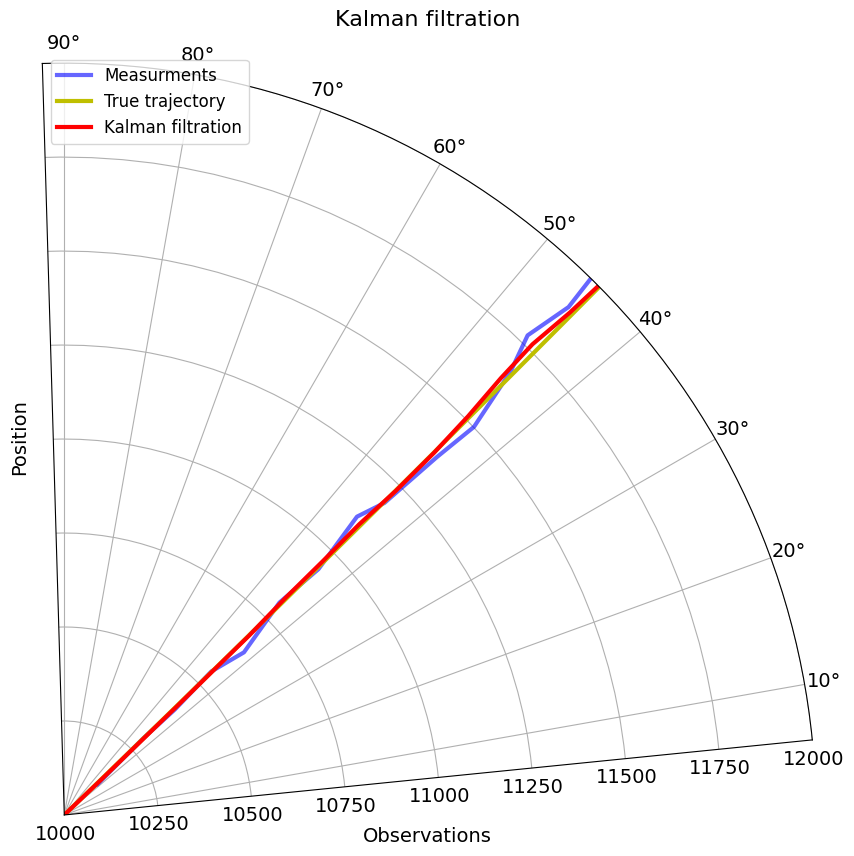

In [234]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': 'polar'})
ax.set_title("Kalman filtration", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
ax.plot(betta_meas, D_meas, 'b', alpha = 0.6, linewidth = 3, label = "Measurments")
ax.plot(betta_true, D_true, linewidth=3, label = "True trajectory", c = 'y')
ax.plot(D_betta_Kalman[3], D_betta_Kalman[2],  'r', linewidth = 3, label = "Kalman filtration")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 12)
plt.xlim(0.1, 1.6)
plt.ylim(10000,12000)
plt.show()

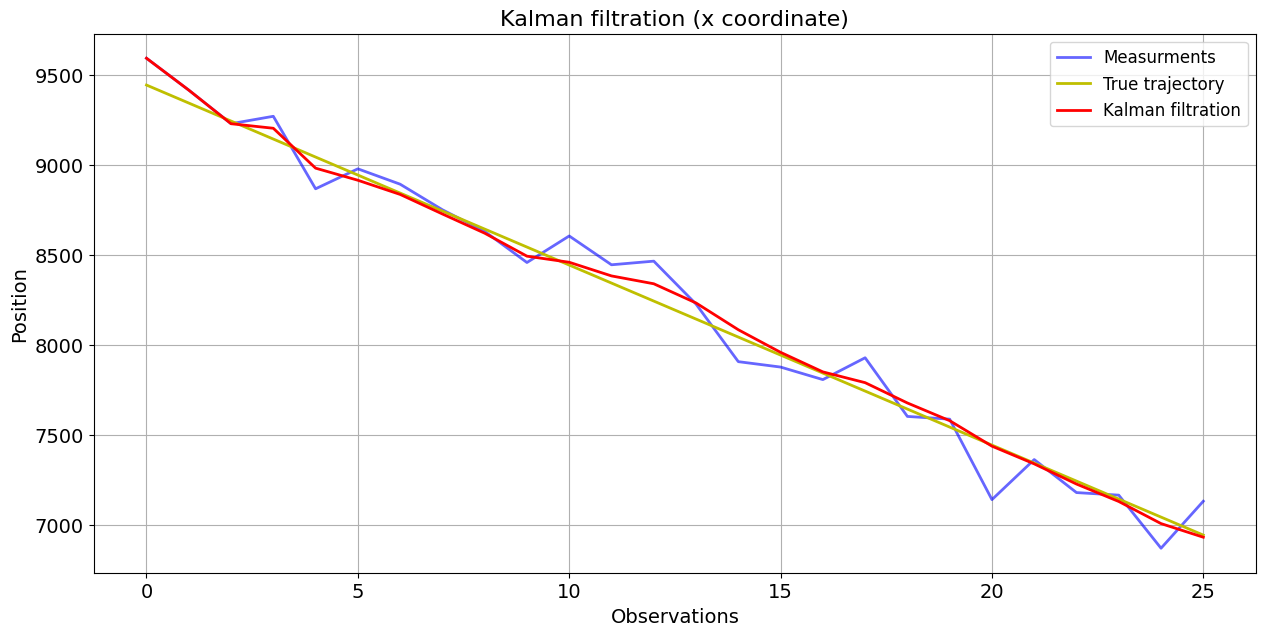

In [235]:
#Plot for x coordinate
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title("Kalman filtration (x coordinate)", fontsize = 16)
ax.set_ylabel("Position", fontsize = 14)
ax.set_xlabel("Observations", fontsize = 14)
ax.plot(Z_meas[0, :], 'b', alpha = 0.6, linewidth = 2, label = "Measurments")
ax.plot(X_true[0, :], linewidth=2, label = "True trajectory", c = 'y')
ax.plot(X_Kalman[0, :], 'r', linewidth = 2, label = "Kalman filtration")

ax.tick_params(labelsize = 14)
ax.legend(fontsize = 12)
ax.grid()

In [236]:
""" #Question 10. Kalman errors (500 iterations)
M_ = 500
def errors(M, X_0_, P_0_, X_true_, R_):
    mistake_D_pred = np.zeros((2, N, M))
    mistake_betta_pred = np.zeros((2, N, M))
    mistake_D_filt = np.zeros((2, N, M))
    mistake_betta_filt = np.zeros((2, N, M))

    for m in range (M):
        #P_ = np.zeros((4, 4, N))

        X_true_M, D_true_M, betta_true_M = true_trajectory_(X_true_, N)
        Z_meas_M, D_meas_M, betta_meas_M = measurments(D_true_M, betta_true_M, N)
        #print(D_true_M.shape, betta_true_M.shape )
        X_Kalman_M, P_Kalman_M, D_betta_Kalman_M, K_Kalman_M = Kalman(X_0_, P_0_, R_, N, Z_meas_M)
        #print(D_true_M.shape, betta_true_M.shape )

        mistake_D_pred[:, :, m] = (D_true_M - D_betta_Kalman_M[0, :]) ** 2
        mistake_betta_pred[:, :, m] = (betta_true_M - D_betta_Kalman_M[1, :]) ** 2

        mistake_D_filt[:, :, m] = (D_true_M - D_betta_Kalman_M[2, :]) ** 2
        mistake_betta_filt[:, :, m] = (betta_true_M - D_betta_Kalman_M[3, :]) ** 2

    Final_err_D_pred = np.sqrt(np.sum(mistake_D_pred, axis = 2) / (M - 1))
    Final_err_betta_pred = np.sqrt(np.sum(mistake_betta_pred, axis = 2) / (M - 1))

    Final_err_D_filt = np.sqrt(np.sum(mistake_D_filt, axis = 2) / (M - 1))
    Final_err_betta_filt = np.sqrt(np.sum(mistake_betta_filt, axis = 2) / (M - 1))

    return Final_err_D_pred, Final_err_betta_pred, Final_err_D_filt, Final_err_betta_filt, P_Kalman_M """

' #Question 10. Kalman errors (500 iterations)\nM_ = 500\ndef errors(M, X_0_, P_0_, X_true_, R_):\n    mistake_D_pred = np.zeros((2, N, M))\n    mistake_betta_pred = np.zeros((2, N, M))\n    mistake_D_filt = np.zeros((2, N, M))\n    mistake_betta_filt = np.zeros((2, N, M))\n\n    for m in range (M):\n        #P_ = np.zeros((4, 4, N))\n\n        X_true_M, D_true_M, betta_true_M = true_trajectory_(X_true_, N)\n        Z_meas_M, D_meas_M, betta_meas_M = measurments(D_true_M, betta_true_M, N)\n        #print(D_true_M.shape, betta_true_M.shape )\n        X_Kalman_M, P_Kalman_M, D_betta_Kalman_M, K_Kalman_M = Kalman(X_0_, P_0_, R_, N, Z_meas_M)\n        #print(D_true_M.shape, betta_true_M.shape )\n\n        mistake_D_pred[:, :, m] = (D_true_M - D_betta_Kalman_M[0, :]) ** 2\n        mistake_betta_pred[:, :, m] = (betta_true_M - D_betta_Kalman_M[1, :]) ** 2\n\n        mistake_D_filt[:, :, m] = (D_true_M - D_betta_Kalman_M[2, :]) ** 2\n        mistake_betta_filt[:, :, m] = (betta_true_M - D_bet

In [237]:
#Question 10. Kalman errors (500 iterations)
M_ = 500
def errors(M, X_0_, P_0_, X_true_, R_, sigma_D, sigma_betta):
    mistake_D_pred = np.zeros((2, N, M))
    mistake_betta_pred = np.zeros((2, N, M))
    mistake_D_filt = np.zeros((2, N, M))
    mistake_betta_filt = np.zeros((2, N, M))

    for m in range (M):
        #P_ = np.zeros((4, 4, N))

        X_true_M, D_true_M, betta_true_M = true_trajectory_(X_true_, N)
        Z_meas_M, D_meas_M, betta_meas_M = measurments(D_true_M, betta_true_M, sigma_D, sigma_betta, N)
        #print(D_true_M.shape, betta_true_M.shape )
        X_Kalman_M, P_Kalman_M, D_betta_Kalman_M, K_Kalman_M = Kalman(X_0_, P_0_, R_, N, Z_meas_M)
        #print(D_true_M.shape, betta_true_M.shape )

        mistake_D_pred[:, :, m] = (D_true_M - D_betta_Kalman_M[0, :]) ** 2
        mistake_betta_pred[:, :, m] = (betta_true_M - D_betta_Kalman_M[1, :]) ** 2

        mistake_D_filt[:, :, m] = (D_true_M - D_betta_Kalman_M[2, :]) ** 2
        mistake_betta_filt[:, :, m] = (betta_true_M - D_betta_Kalman_M[3, :]) ** 2

    Final_err_D_pred = np.sqrt(np.sum(mistake_D_pred, axis = 2) / (M - 1))
    Final_err_betta_pred = np.sqrt(np.sum(mistake_betta_pred, axis = 2) / (M - 1))

    Final_err_D_filt = np.sqrt(np.sum(mistake_D_filt, axis = 2) / (M - 1))
    Final_err_betta_filt = np.sqrt(np.sum(mistake_betta_filt, axis = 2) / (M - 1))

    return Final_err_D_pred, Final_err_betta_pred, Final_err_D_filt, Final_err_betta_filt, P_Kalman_M

In [238]:
Err_D_pred, Err_betta_pred, Err_D_filt, Err_betta_filt, P_Kalman_err = errors(M_, X_0, P_0, X_true_0, R, sigma_D_, sigma_betta_)

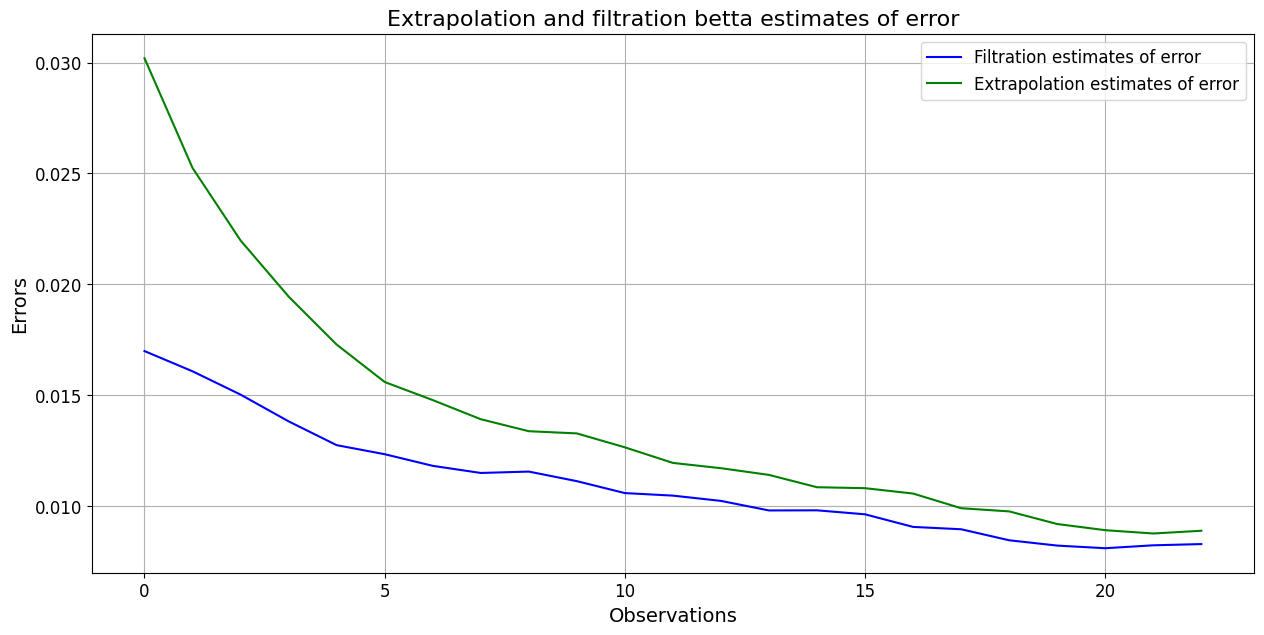

In [239]:
#Extrapolation and filtration betta estimates of error
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Extrapolation and filtration betta estimates of error", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)

e.plot(Err_betta_filt[0, 3:], label = "Filtration estimates of error", color = "b")
e.plot(Err_betta_pred[0, 3:], label = "Extrapolation estimates of error", color = "g")
e.tick_params(labelsize = 12)
e.legend(fontsize = 12)
e.grid()

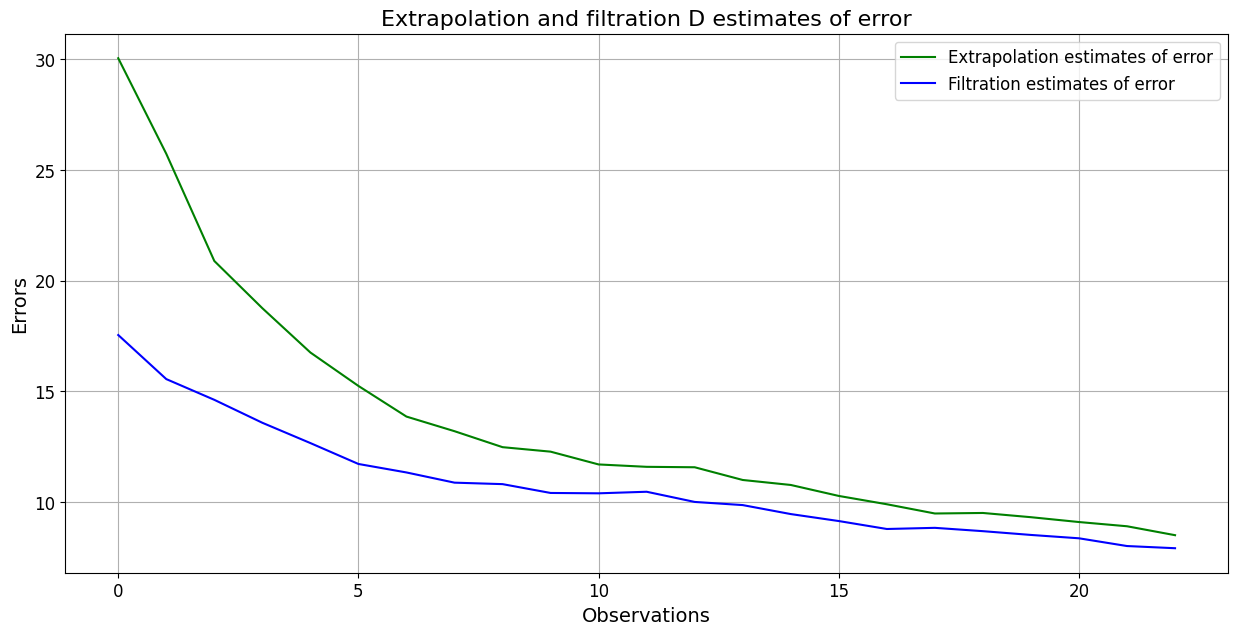

In [240]:
#Extrapolation and filtration D estimates of error
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Extrapolation and filtration D estimates of error", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(Err_D_pred[0, 3:], label = "Extrapolation estimates of error", color = "g")
e.plot(Err_D_filt[0, 3:], label = "Filtration estimates of error", color = "b")

e.tick_params(labelsize = 12)
e.legend(fontsize = 12)
e.grid()

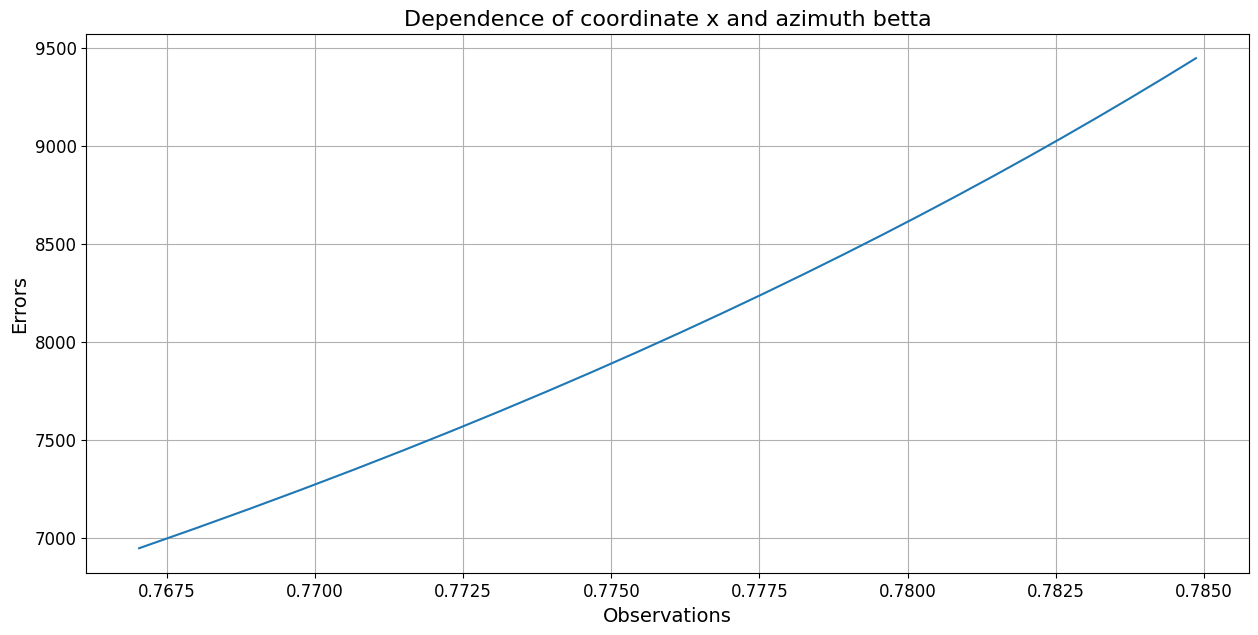

In [241]:
#Quastion 11. Dependence of coordinate x and azimuth betta
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Dependence of coordinate x and azimuth betta", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(betta_true, X_true[0, :])
e.tick_params(labelsize = 12)
e.grid()

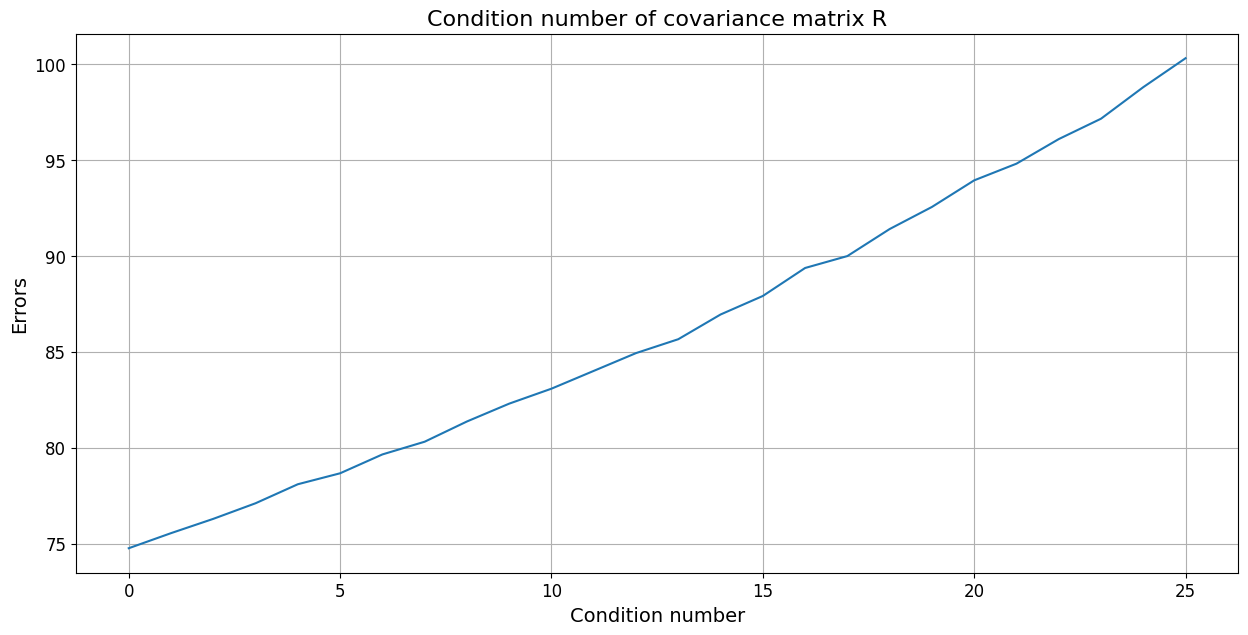

In [242]:
#Question 12. Condition number of covariance matrix R
lambda_1 = sigma_D_ ** 2
lambda_2 = sigma_betta_ ** 2 * (D_meas[:])

alpha = lambda_1 / lambda_2 
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Condition number of covariance matrix R", fontsize = 16)
e.set_xlabel("Condition number", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(alpha)
e.tick_params(labelsize = 12)
e.grid()

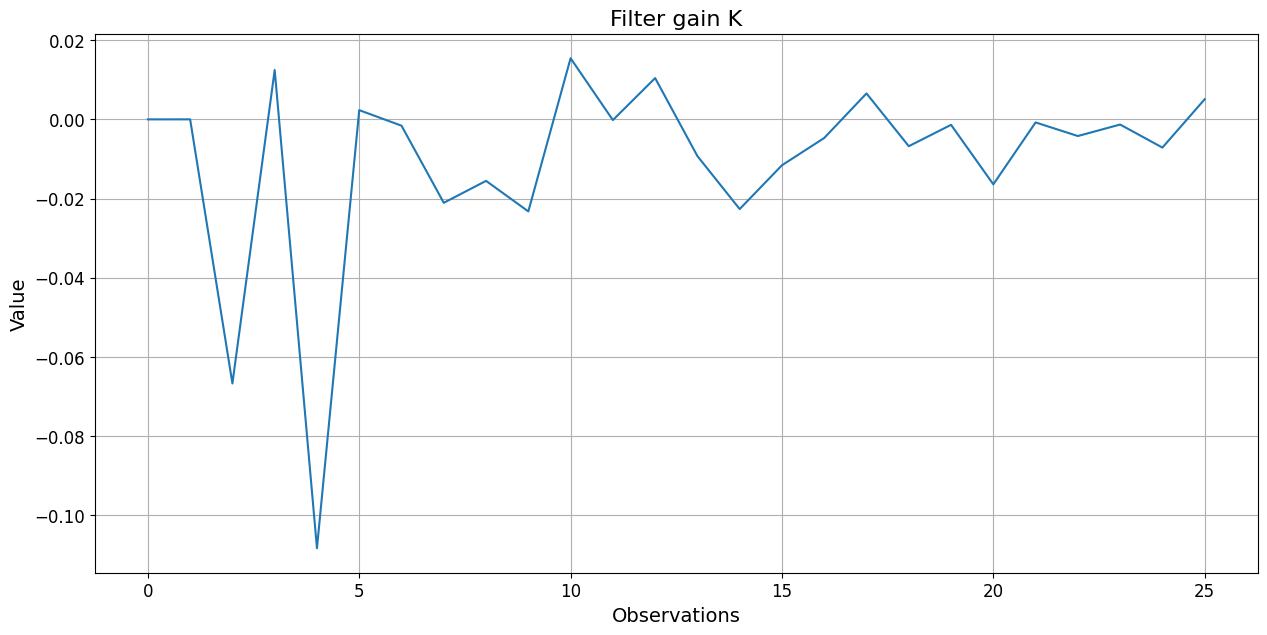

In [243]:
#Quastion 13. Filter gain K analizes 
fig, e = plt.subplots(figsize=(15, 7))
e.set_title("Filter gain K", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Value", fontsize = 14)
e.plot(K_Kalman[1, 1, :])
e.tick_params(labelsize = 12)
e.grid()

In [244]:
#Question 14. Kalman with closer object
X_true_0_14 = np.array([[3500/np.sqrt(2)], [-50], [3500/np.sqrt(2)], [-45]])

D_0_14 = np.sqrt(X_true_0_14[0] ** 2 + X_true_0_14[2]**2)

betta_0_14 = np.arctan(X_true_0_14[0]/X_true_0_14[2])
betta_true_14 = np.zeros((N, 1))

X_true_14, D_true_14, betta_true_14 = true_trajectory_(X_true_0_14, N)

Z_meas_14, D_meas_14, betta_meas_14 = measurments(D_true_14, betta_true_14, sigma_D_, sigma_betta_, N)
R_14 = R_(D_meas_14, betta_meas_14, sigma_D_, sigma_betta_, N)

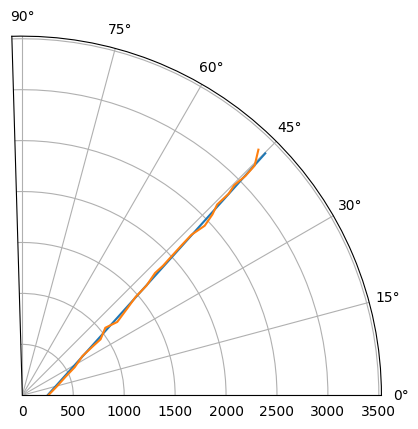

In [245]:
#Plotting true trajectory and measurments
plt.polar(betta_true_14, D_true_14)
plt.polar(betta_meas_14, D_meas_14)
plt.xlim(0, 1.6)
plt.show()

In [246]:
#Quastion 15. Errors calculating

Err_D_pred_14, Err_betta_pred_14, Err_D_filt_14, Err_betta_filt_14, P_Kalman_err_14 = errors(M_, X_0, P_0, X_true_0_14, R_14, sigma_D_, sigma_betta_)

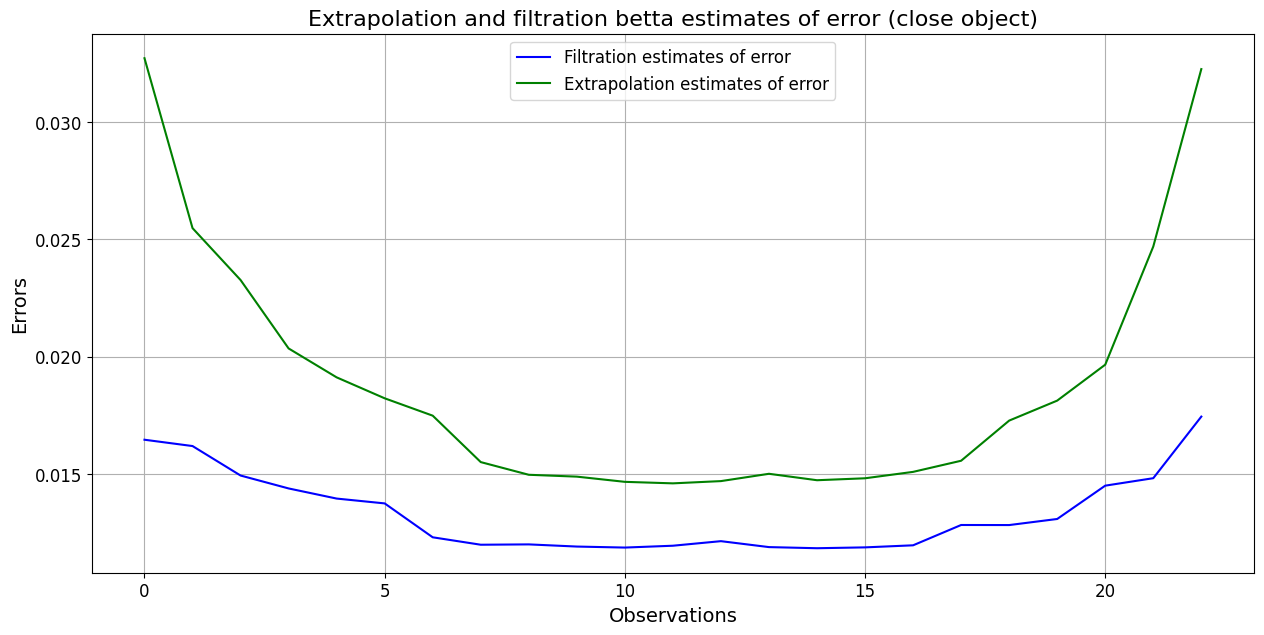

In [247]:
#Extrapolation and filtration betta estimates of error
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Extrapolation and filtration betta estimates of error (close object)", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)

e.plot(Err_betta_filt_14[0, 3:], label = "Filtration estimates of error", color = "b")
e.plot(Err_betta_pred_14[0, 3:], label = "Extrapolation estimates of error", color = "g")
e.tick_params(labelsize = 12)
e.legend(fontsize = 12)
e.grid()

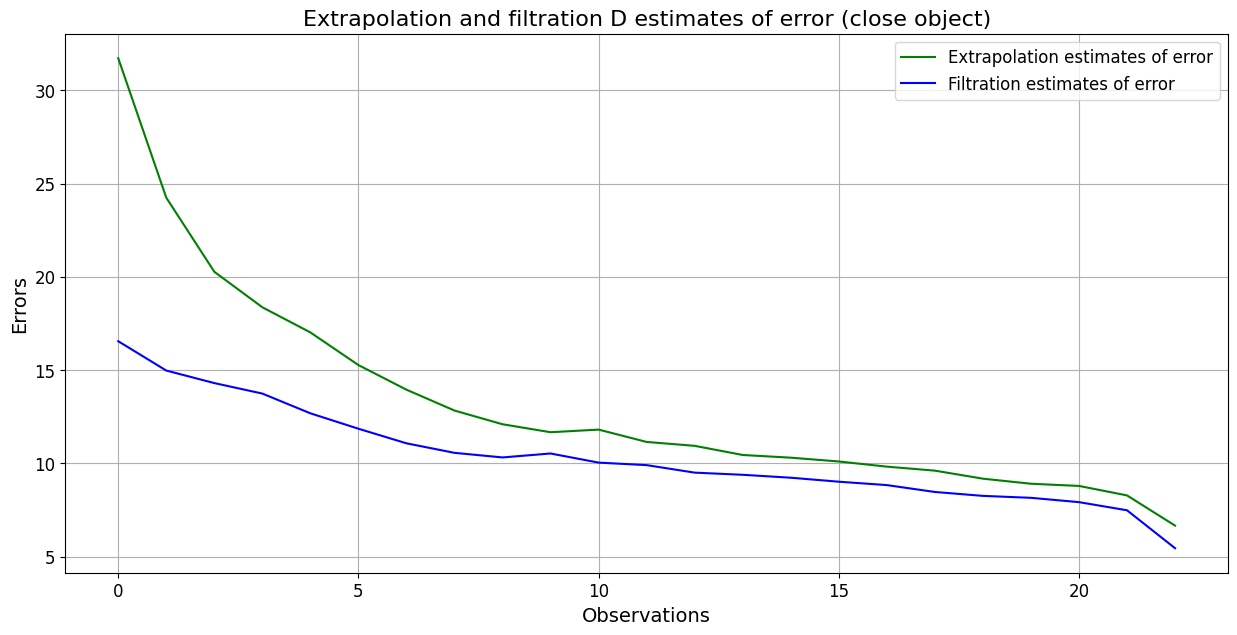

In [248]:
#Extrapolation and filtration D estimates of error
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Extrapolation and filtration D estimates of error (close object)", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(Err_D_pred_14[0, 3:], label = "Extrapolation estimates of error", color = "g")
e.plot(Err_D_filt_14[0, 3:], label = "Filtration estimates of error", color = "b")

e.tick_params(labelsize = 12)
e.legend(fontsize = 12)
e.grid()

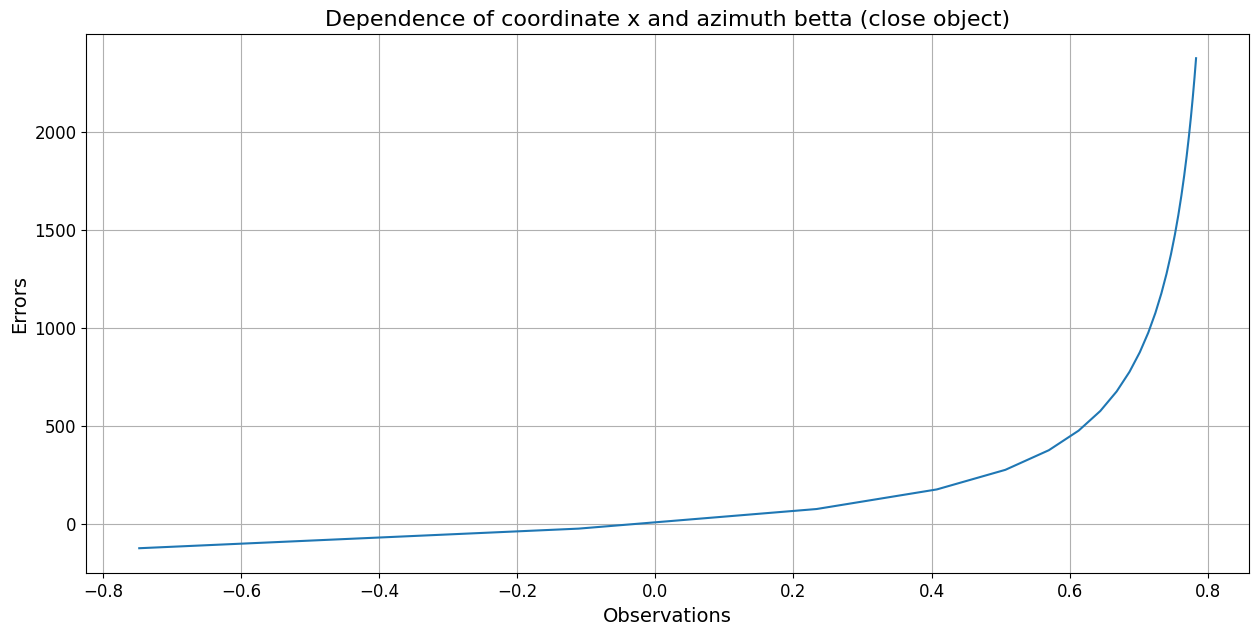

In [249]:
#Quastion 16. Dependence of coordinate 𝑥 on azimuth 𝛽 
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Dependence of coordinate x and azimuth betta (close object)", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(betta_true_14, X_true_14[0, :])
e.tick_params(labelsize = 12)
e.grid()

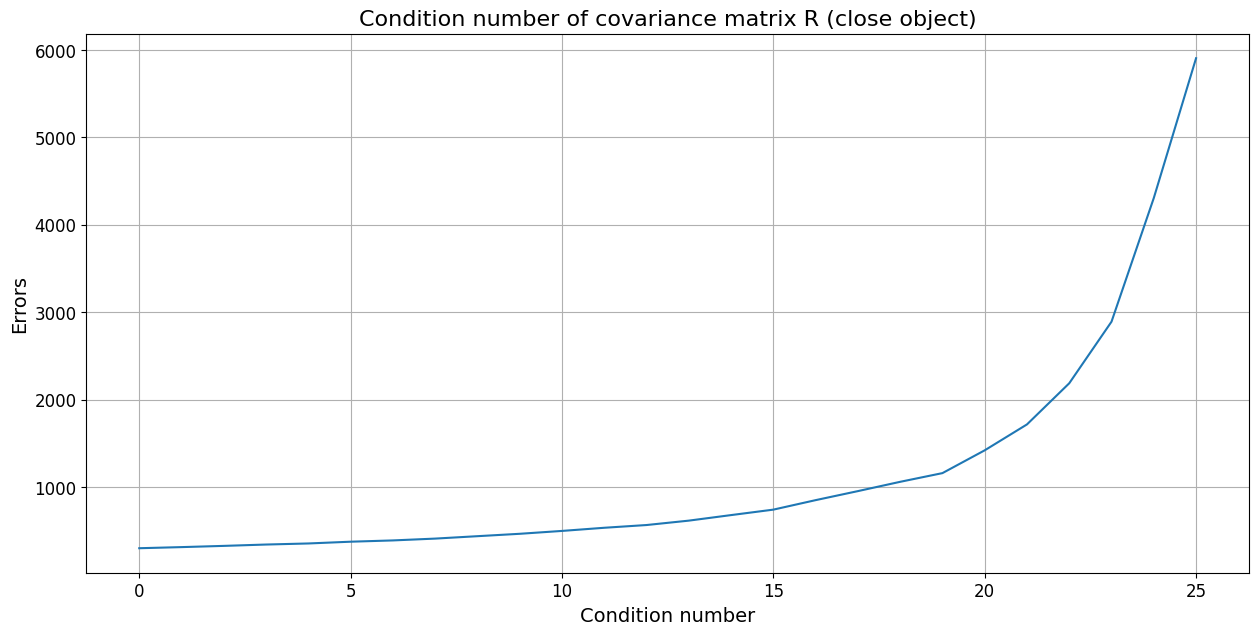

In [250]:
#Question 17. Condition number of covariance matrix R
lambda_1 = sigma_D_ ** 2
lambda_2 = sigma_betta_ ** 2 * (D_meas_14[:])

alpha = lambda_1 / lambda_2 
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Condition number of covariance matrix R (close object)", fontsize = 16)
e.set_xlabel("Condition number", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(alpha)
e.tick_params(labelsize = 12)
e.grid()

In [251]:
#Question 19. Kalman with close object and new noise
X_true_0_19 = np.array([[3500/np.sqrt(2)], [-50], [3500/np.sqrt(2)], [-45]])

sigma_D_19 = 50
sigma_betta_19 = 0.0015

X_true_19, D_true_19, betta_true_19 = true_trajectory_(X_true_0_19, N)

Z_meas_19, D_meas_19, betta_meas_19 = measurments(D_true_19, betta_true_19, sigma_D_19, sigma_betta_19, N)
R_19 = R_(D_meas_19, betta_meas_19, sigma_D_19, sigma_betta_19, N)


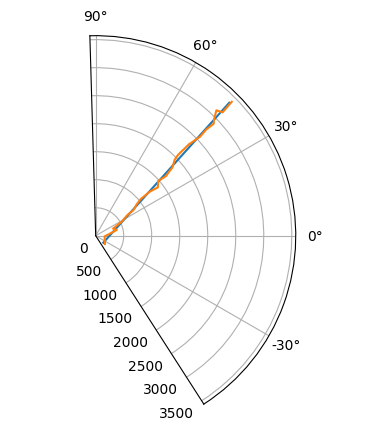

In [252]:
#Plotting true trajectory and measurments
plt.polar(betta_true_19, D_true_19)
plt.polar(betta_meas_19, D_meas_19)
plt.xlim(-1.0, 1.6)
plt.show()

In [253]:
#Quastion 19_1. Errors calculating

Err_D_pred_19, Err_betta_pred_19, Err_D_filt_19, Err_betta_filt_19, P_Kalman_err_19 = errors(M_, X_0, P_0, X_true_0_19, R_19, sigma_D_19, sigma_betta_19)

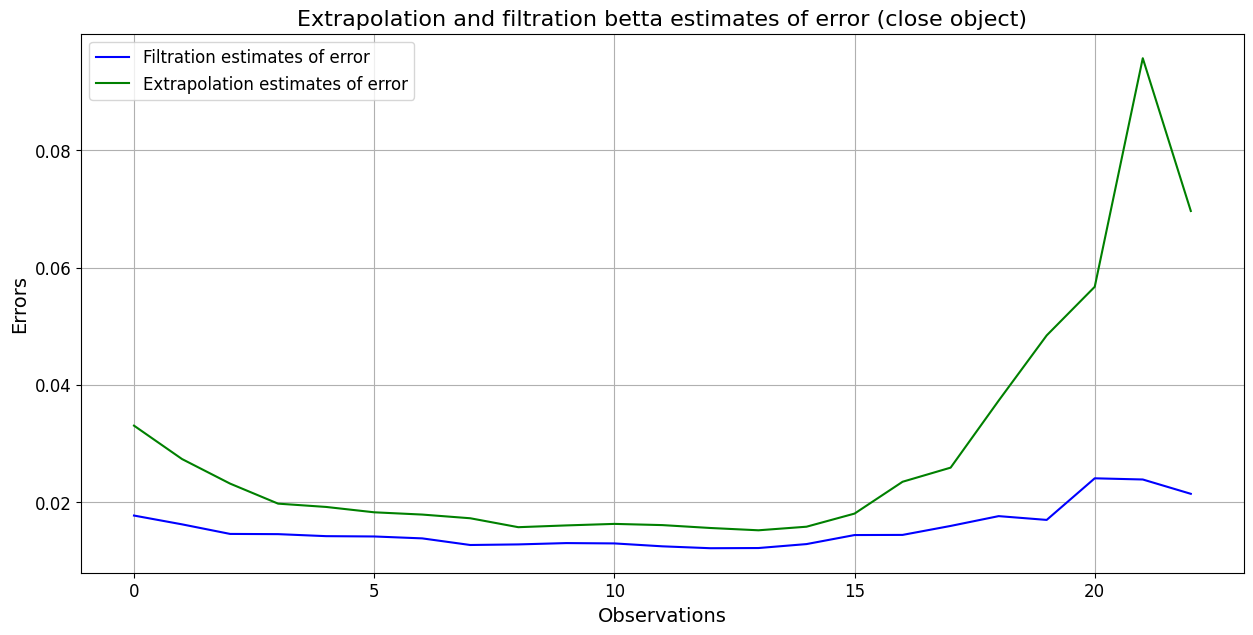

In [254]:
#Extrapolation and filtration betta estimates of error
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Extrapolation and filtration betta estimates of error (close object)", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)

e.plot(Err_betta_filt_19[0, 3:], label = "Filtration estimates of error", color = "b")
e.plot(Err_betta_pred_19[0, 3:], label = "Extrapolation estimates of error", color = "g")
e.tick_params(labelsize = 12)
e.legend(fontsize = 12)
e.grid()

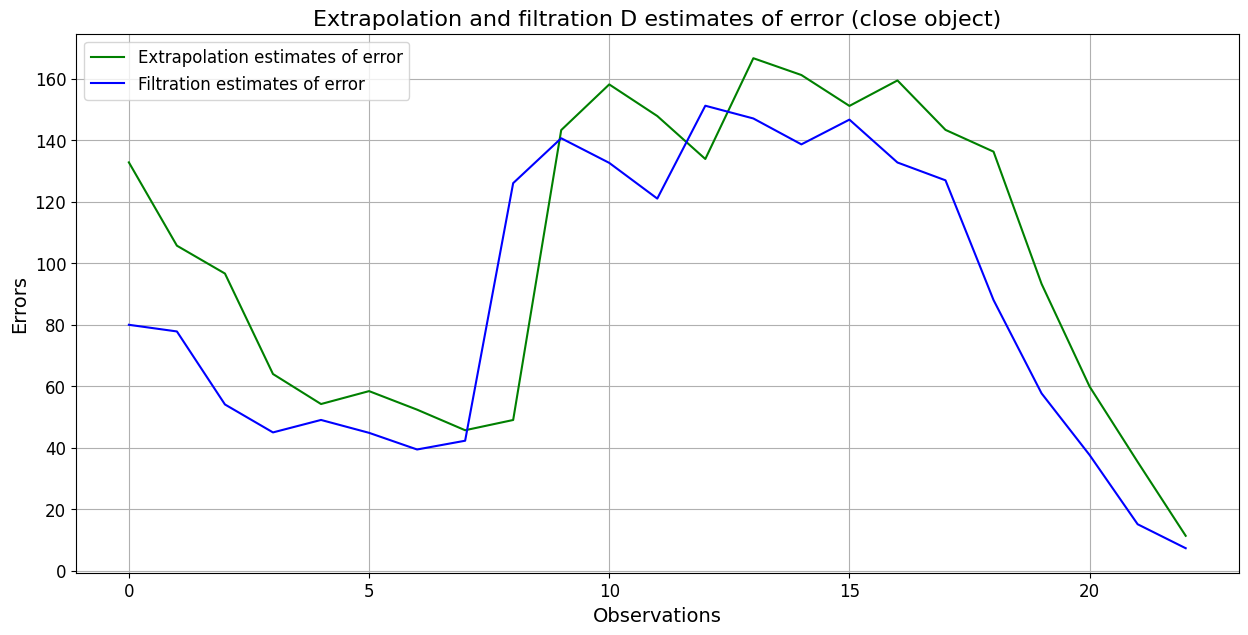

In [255]:
#Extrapolation and filtration D estimates of error
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Extrapolation and filtration D estimates of error (close object)", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(Err_D_pred_19[0, 3:], label = "Extrapolation estimates of error", color = "g")
e.plot(Err_D_filt_19[0, 3:], label = "Filtration estimates of error", color = "b")

e.tick_params(labelsize = 12)
e.legend(fontsize = 12)
e.grid()

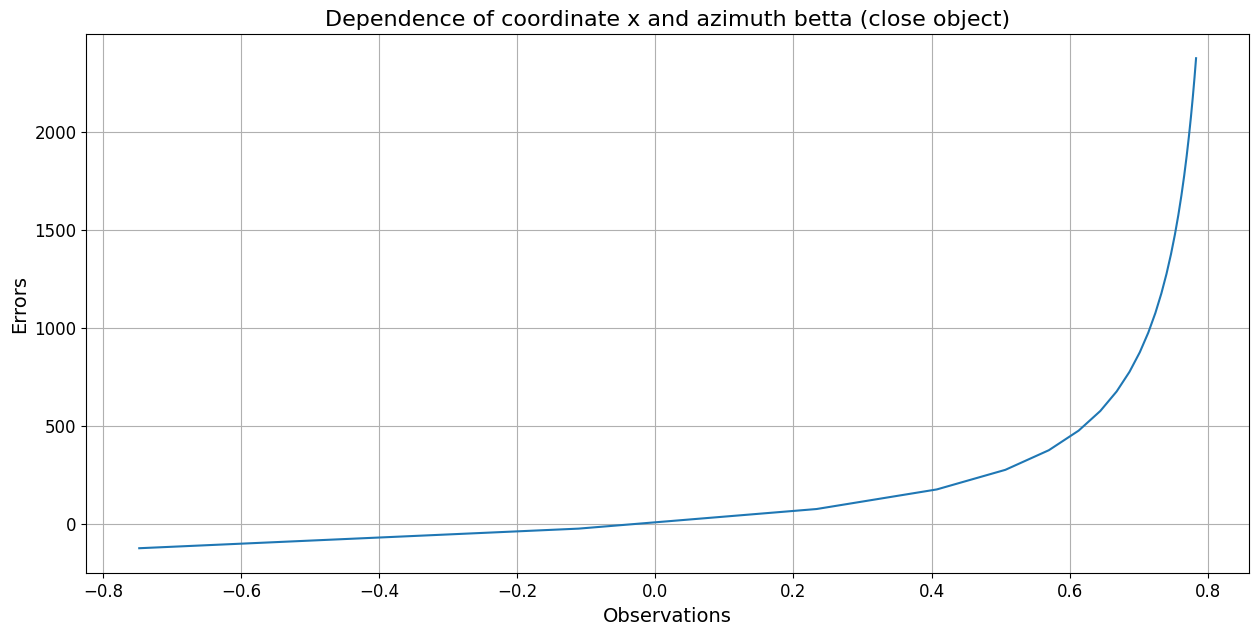

In [256]:
#Question 19_2. Dependence of coordinate 𝑥 on azimuth 𝛽 
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Dependence of coordinate x and azimuth betta (close object)", fontsize = 16)
e.set_xlabel("Observations", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(betta_true_19, X_true_19[0, :])
e.tick_params(labelsize = 12)
e.grid()

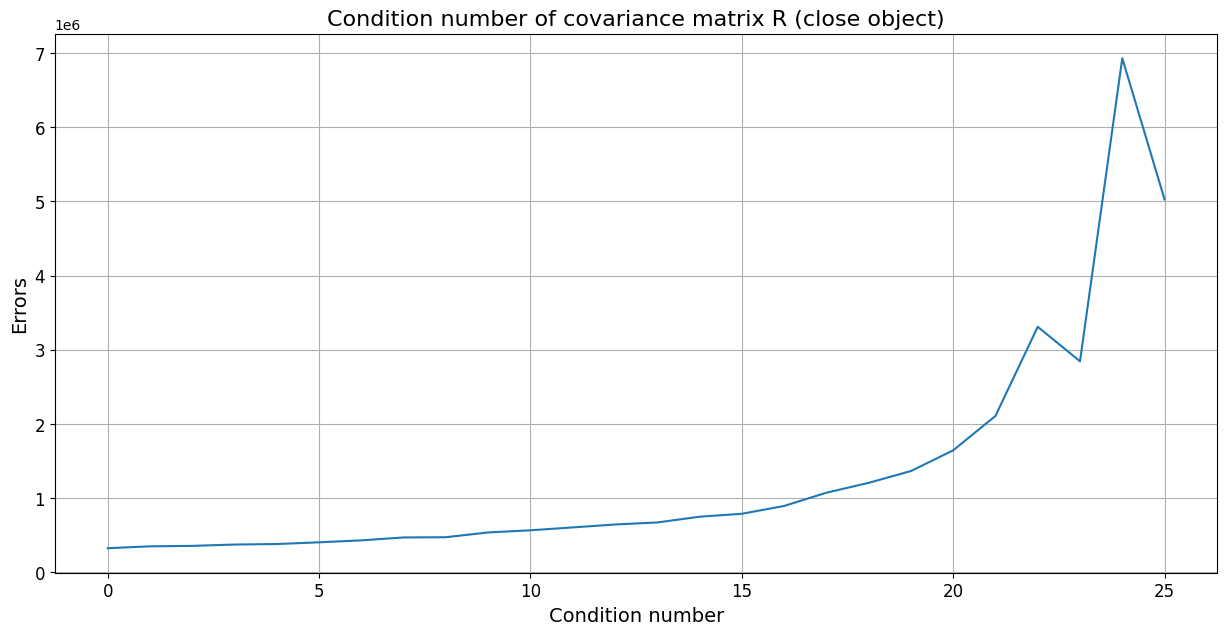

In [259]:
#Question 19_3. Condition number of covariance matrix R
lambda_1 = sigma_D_19 ** 2
lambda_2 = sigma_betta_19 ** 2 * (D_meas_19[:])

alpha = (lambda_1 / lambda_2) ** (1)
fig, e = plt.subplots(figsize=(15,7))
e.set_title("Condition number of covariance matrix R (close object)", fontsize = 16)
e.set_xlabel("Condition number", fontsize = 14)
e.set_ylabel("Errors", fontsize = 14)
e.plot(alpha)
e.tick_params(labelsize = 12)
e.grid()